In [62]:
!rm -rf *.zip
!wget https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip

--2024-10-19 22:12:35--  https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.210.207, 173.194.212.207, 173.194.215.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.210.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  --.-KB/s    in 0.06s   

2024-10-19 22:12:35 (210 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13568290/13568290]



In [63]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [64]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [65]:
df = pd.read_csv(csv_path)

In [66]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [67]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    data = np.array([dataset[i-history_size:i].values.reshape(-1, 1) for i in range(start_index, end_index)])
    labels = np.array([dataset[i+target_size] for i in range(start_index, end_index)])

    return data, labels

In [68]:
TRAIN_SPLIT = 30000

In [69]:
tf.random.set_seed(13)

In [70]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

,T (degC)
Date Time,
01.01.2009 00:10:00,-8.02
01.01.2009 00:20:00,-8.41
01.01.2009 00:30:00,-8.51
01.01.2009 00:40:00,-8.31
01.01.2009 00:50:00,-8.27


array([<Axes: xlabel='Date Time'>], dtype=object)

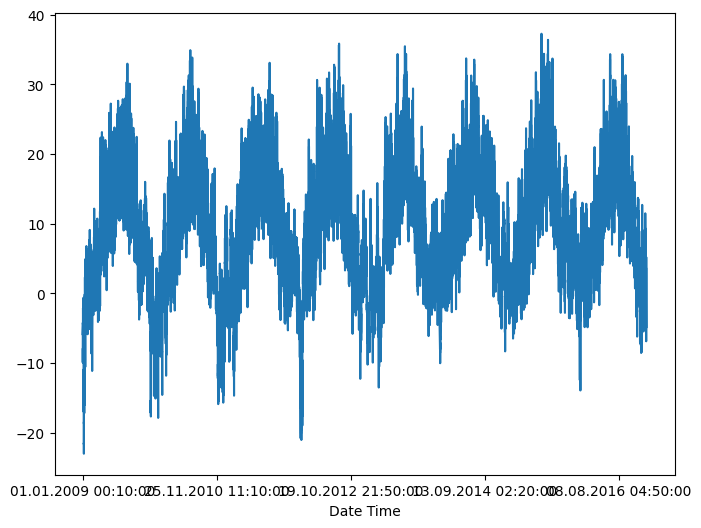

In [71]:
uni_data.plot(subplots=True)

In [72]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [73]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [74]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

<ipython-input-67-7f45380ac1e8>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = np.array([dataset[i+target_size] for i in range(start_index, end_index)])


In [76]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.87221721]
 [-1.91724246]
 [-1.9287874 ]
 [-1.90569753]
 [-1.90107955]
 [-1.87568069]
 [-1.82603745]
 [-1.82603745]
 [-1.85951777]
 [-1.91955145]
 [-1.95764975]
 [-1.97150367]
 [-1.96804019]
 [-1.9657312 ]
 [-1.94610481]
 [-1.94610481]
 [-1.95072278]
 [-1.96342222]
 [-1.9668857 ]
 [-1.97843064]]

 Target temperature to predict
-1.9784306360911001


In [77]:
def create_time_steps(length):
  return list(range(-length, 0))

In [78]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

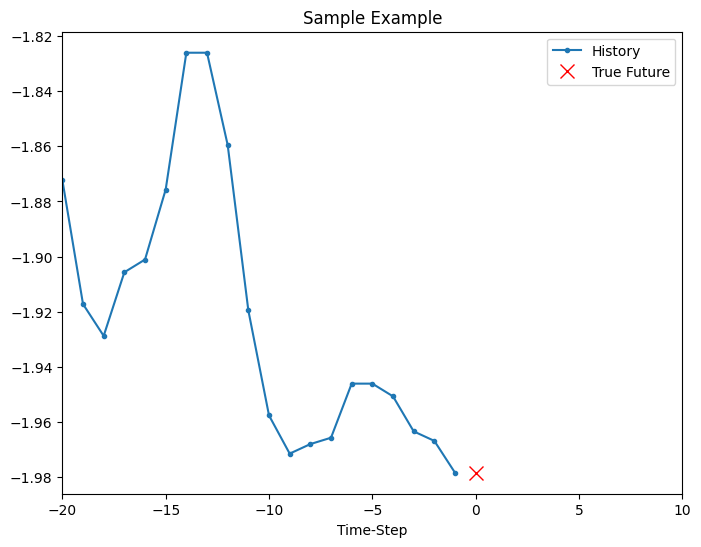

In [79]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [80]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

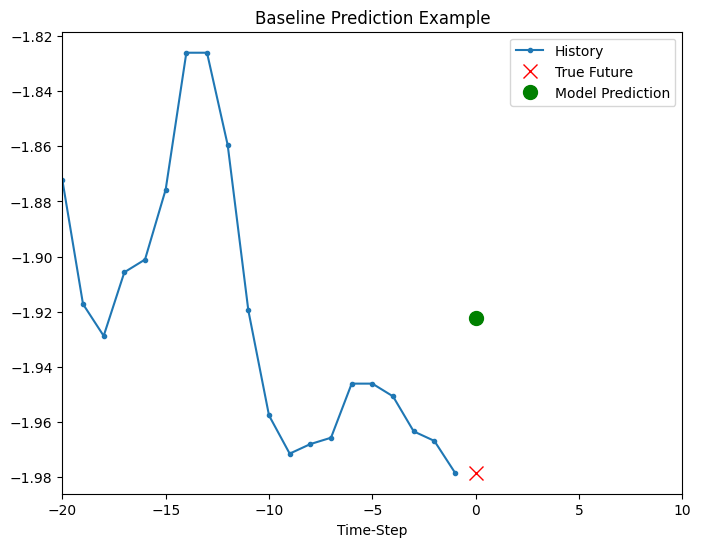

In [81]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

#Добавляем НС

In [82]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [83]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [84]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step  
(256, 1)


In [85]:
print(x_train_uni.shape)

(29980, 20, 1)


In [86]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.7724 - val_loss: 0.1796
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1266 - val_loss: 0.0504
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0532 - val_loss: 0.0409
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0419 - val_loss: 0.0508
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0365 - val_loss: 0.0319
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0323 - val_loss: 0.0226
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0289 - val_loss: 0.0218
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0268 - val_loss: 0.0296
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0262 - val_loss: 0.0268
Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0233 - val_loss: 0.0183


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


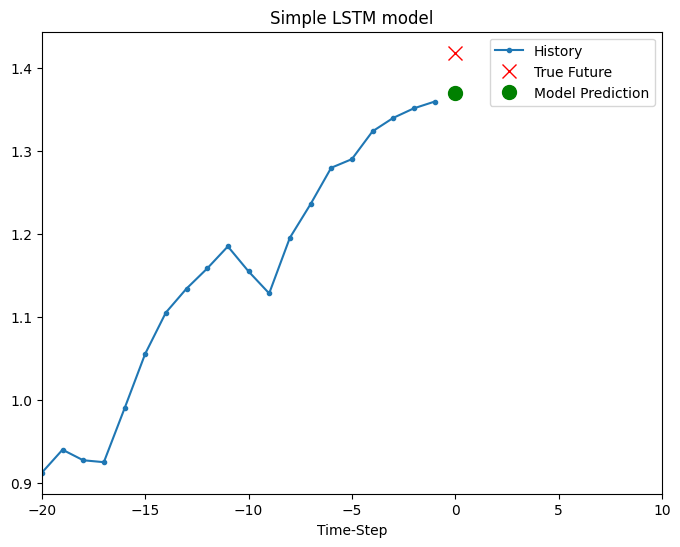

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


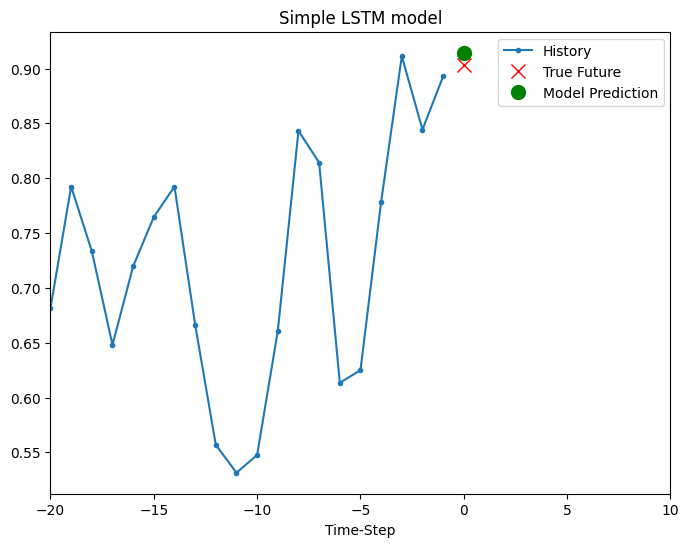

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


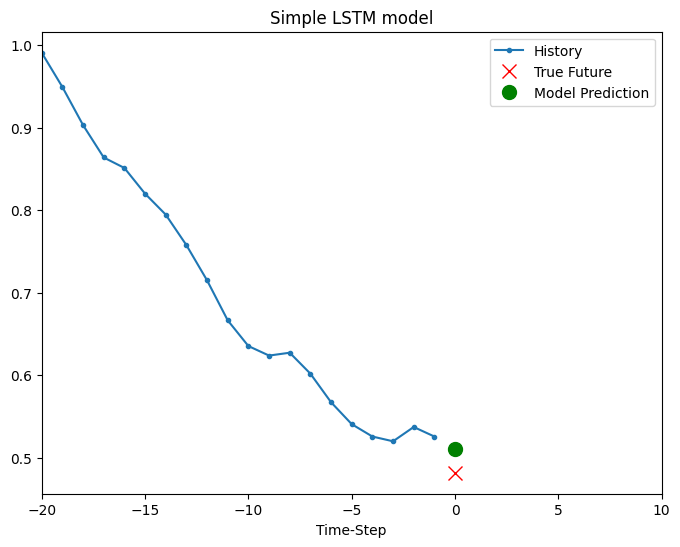

In [87]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

##Прогнозирование на основе многомерного временного ряда

In [88]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [89]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<Axes: xlabel='Date Time'>, <Axes: xlabel='Date Time'>,
       <Axes: xlabel='Date Time'>], dtype=object)

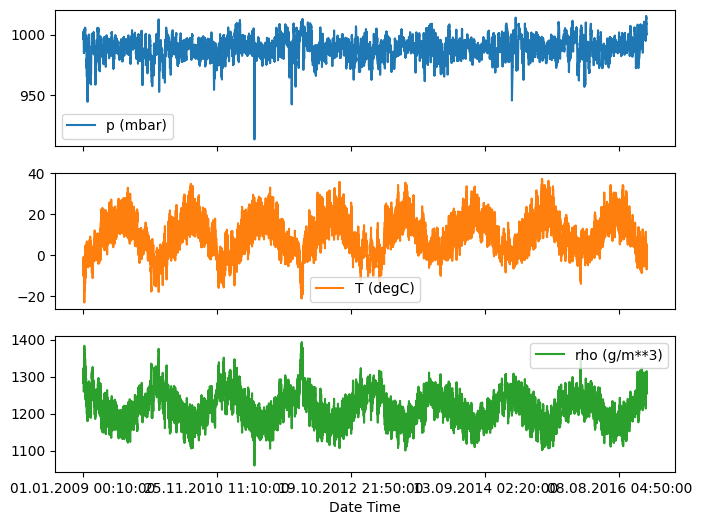

In [90]:
features.plot(subplots=True)

In [91]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [92]:
dataset = (dataset-data_mean)/data_std

###Точечное прогнозирование

In [93]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [94]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [95]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [96]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [97]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [98]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
(256, 1)


In [99]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 25s 100ms/step - loss: 0.3746 - val_loss: 0.2864
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 19s 93ms/step - loss: 0.2550 - val_loss: 0.3289
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 18s 92ms/step - loss: 0.2439 - val_loss: 0.3013
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 18s 92ms/step - loss: 0.2314 - val_loss: 0.2870
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 19s 96ms/step - loss: 0.2164 - val_loss: 0.2658
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 18s 90ms/step - loss: 0.2035 - val_loss: 0.3729
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 18s 92ms/step - loss: 0.1893 - val_loss: 0.3383
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 98ms/step - loss: 0.1770 - val_loss: 0.3160
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step - loss: 0.1672 - val_loss: 0.2930
Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 98ms/step - loss: 0.1618 - val_loss: 0.3408


In [100]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

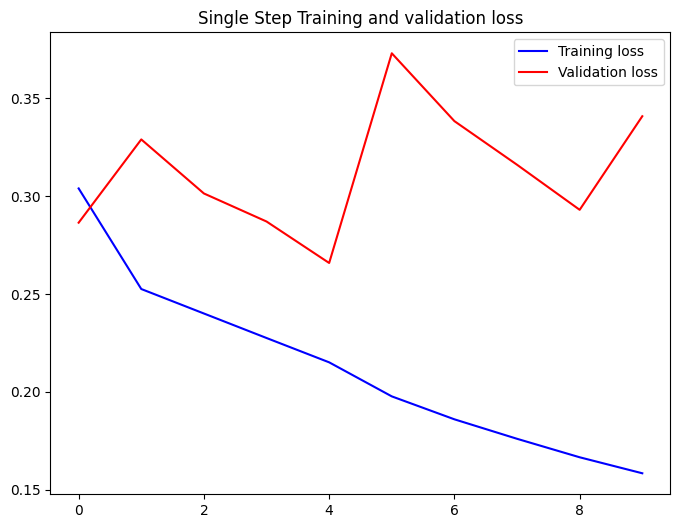

In [101]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


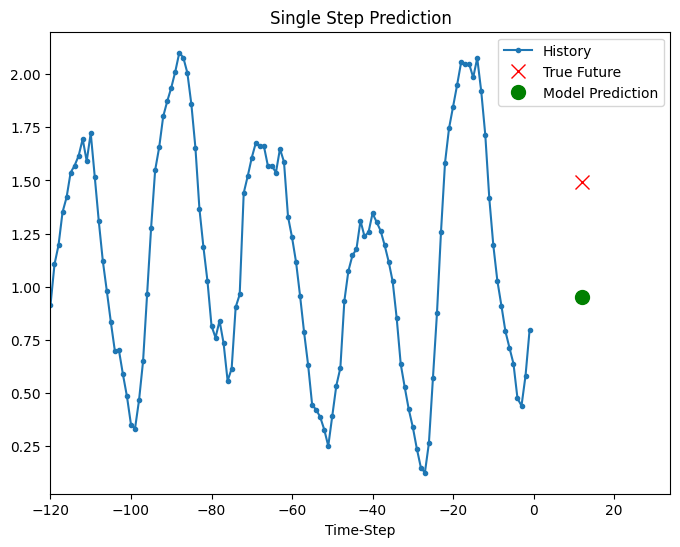

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


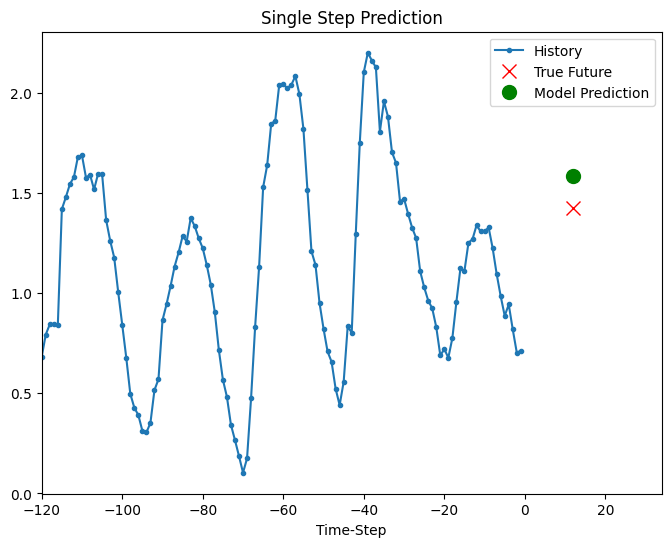

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


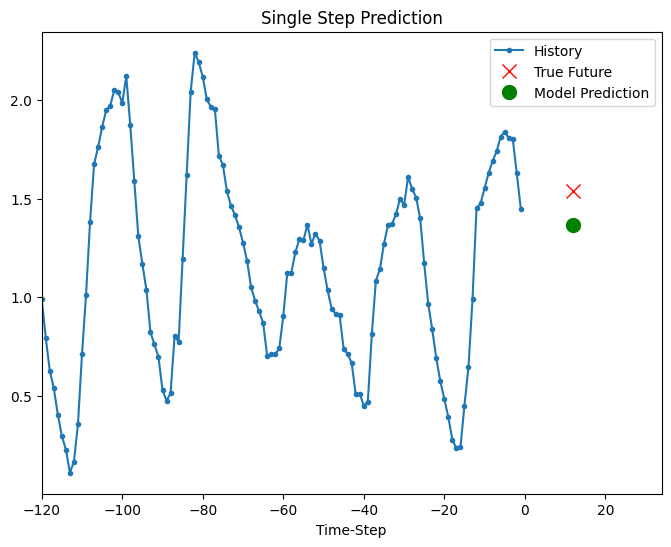

In [102]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

###Интервальное прогнозирование

In [103]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [104]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [105]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [106]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

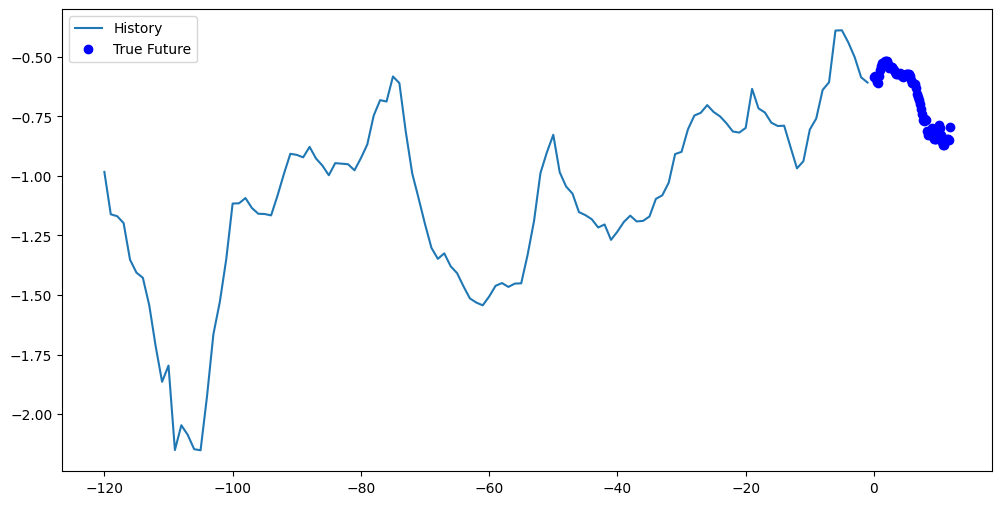

In [107]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [108]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [109]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
(256, 72)


In [110]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 51s 212ms/step - loss: 0.6610 - val_loss: 0.4292
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 34s 170ms/step - loss: 0.3703 - val_loss: 0.2694
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 35s 177ms/step - loss: 3578.5383 - val_loss: 0.3609
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 36s 179ms/step - loss: 5990.8721 - val_loss: 0.3793
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 34s 172ms/step - loss: 3.8687 - val_loss: 0.2934
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 35s 173ms/step - loss: 0.2717 - val_loss: 0.3077
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 34s 169ms/step - loss: 0.2305 - val_loss: 0.3232
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 36s 179ms/step - loss: 0.2092 - val_loss: 0.2258
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 33s 166ms/step - loss: 6.0695 - val_loss: 0.2274
Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 34s 171ms/step - loss: 991.8016 - val_loss: 0.5432


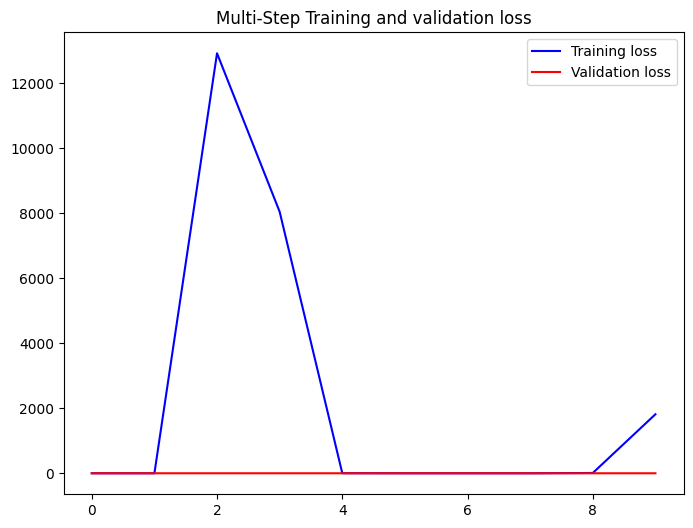

In [111]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


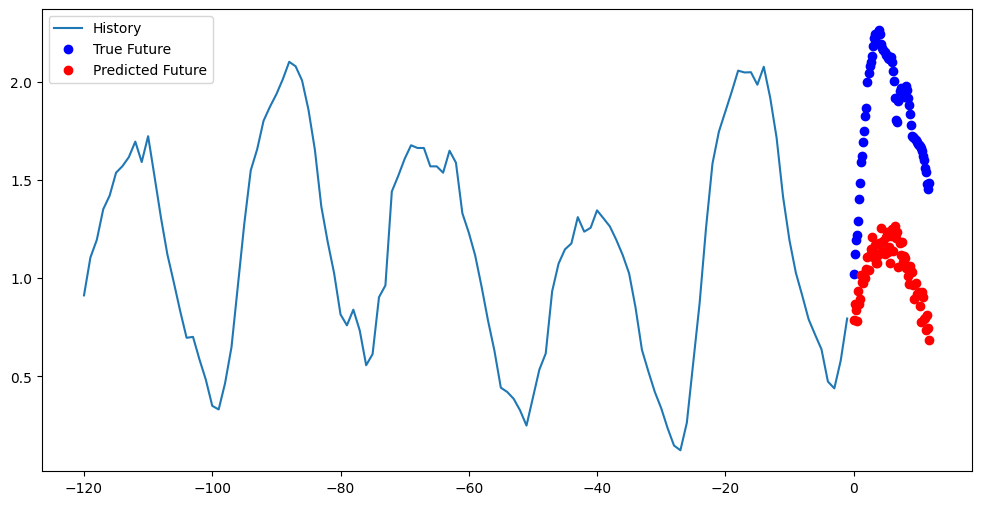

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


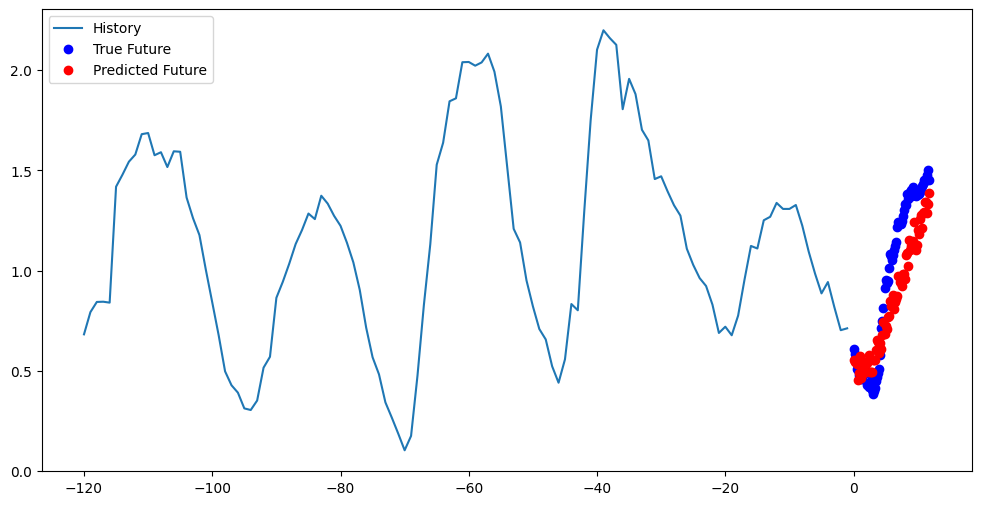

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


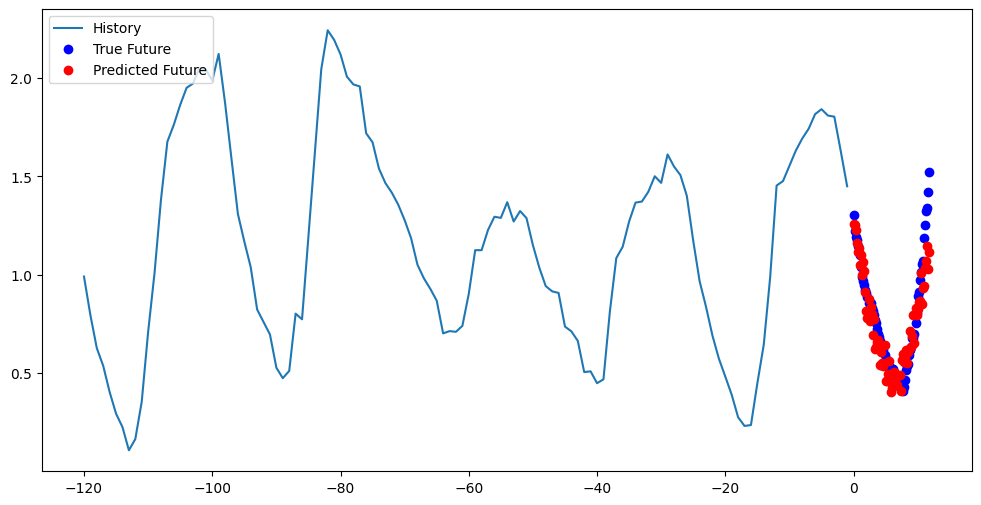

In [112]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])